# Converting Time Series date into Supervised Learning Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Load the data

In [2]:
data_dir = 'data/2024-08-19/'
data = pd.read_csv(
    filepath_or_buffer=f'{data_dir}/rathbone-global.csv',
    usecols=['Date', 'Adj Close'],
    parse_dates=['Date'],
    index_col='Date'
)

data

,Adj Close
Date,
2023-08-21,349.966614
2023-08-22,350.676575
2023-08-23,353.116486
2023-08-24,355.676392
2023-08-25,353.486481
...,...
2024-08-13,422.859985
2024-08-14,427.209991
2024-08-15,427.829987


## Plotting the data

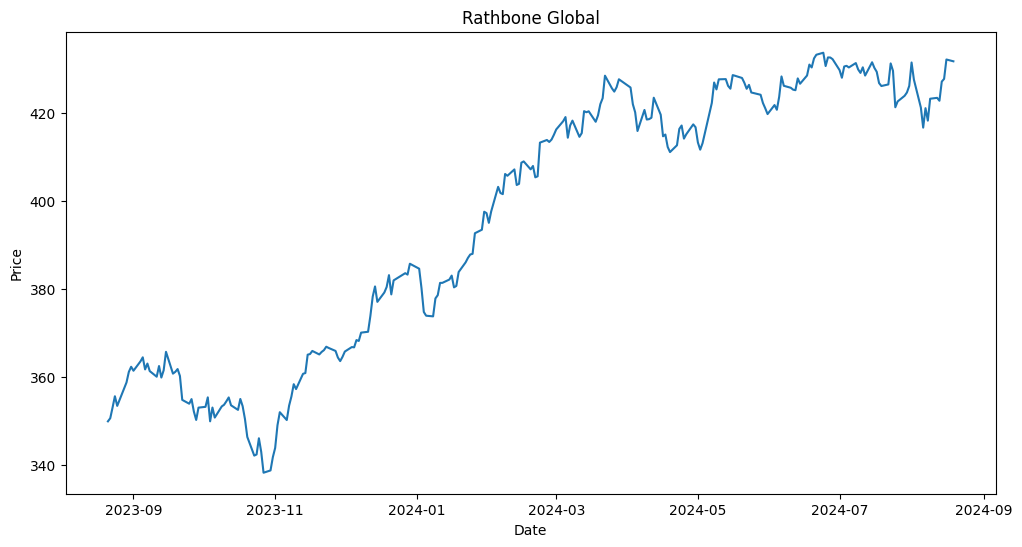

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Adj Close'])
plt.title('Rathbone Global')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

,Adj Close
Date,
2023-08-22,0.002025
2023-08-23,0.006910
2023-08-24,0.007197
2023-08-25,-0.006195
2023-08-29,0.014854
2023-08-30,0.006617
2023-08-31,0.003229
2023-09-01,-0.002490
2023-09-04,0.005830


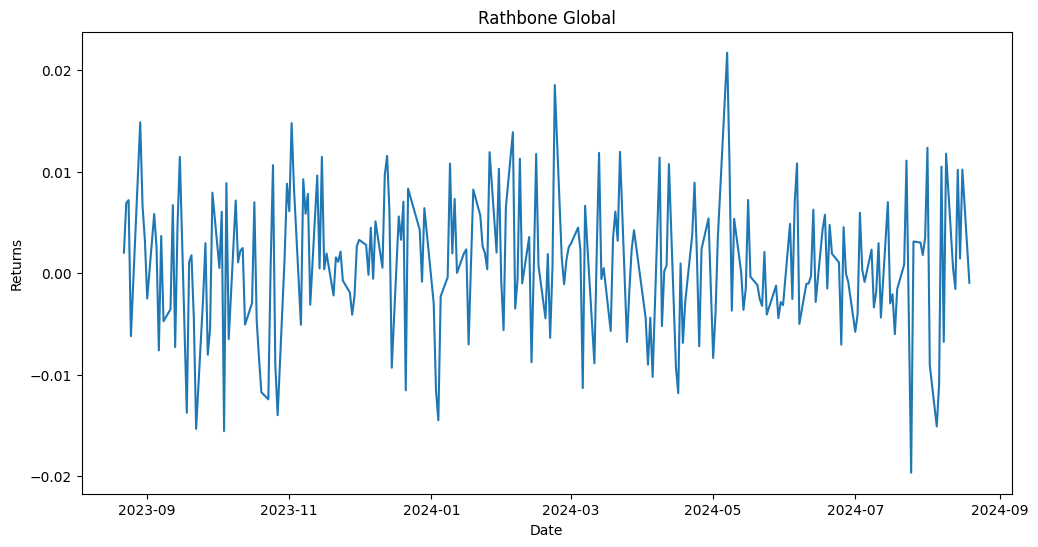

In [4]:
# Calculate periodic returns
returns = (data.diff() / data).dropna()
display(returns.head(10))

plt.figure(figsize=(12, 6))
plt.plot(returns.index, returns['Adj Close'])
plt.title('Rathbone Global')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

## Preprocess Data

In [5]:
data['Return'] = (data['Adj Close'] - data['Adj Close'].shift(1)) / data['Adj Close']
data.dropna(inplace=True)

## Create Lag Feature

In [6]:
def create_lag_features(df, lag=1):
    df_lag = df.copy()
    for i in range(1, lag + 1):
        df_lag[f'lag_{i}'] = df_lag['Adj Close'].shift(i)
    return df_lag

# Create lag features with a window size of 3
data_lagged = create_lag_features(data, lag=3)
data_lagged.dropna(inplace=True)

data_lagged

,Adj Close,Return,lag_1,lag_2,lag_3
Date,,,,,
2023-08-25,353.486481,-0.006195,355.676392,353.116486,350.676575
2023-08-29,358.816254,0.014854,353.486481,355.676392,353.116486
2023-08-30,361.206177,0.006617,358.816254,353.486481,355.676392
2023-08-31,362.376160,0.003229,361.206177,358.816254,353.486481
2023-09-01,361.476166,-0.002490,362.376160,361.206177,358.816254
...,...,...,...,...,...
2024-08-13,422.859985,-0.001561,423.519989,423.320007,418.339996
2024-08-14,427.209991,0.010182,422.859985,423.519989,423.320007
2024-08-15,427.829987,0.001449,427.209991,422.859985,423.519989


## Split the data

Split the data into buckets for training and testing

In [7]:
train_size = int(len(data_lagged) * 0.8)
train = data_lagged.iloc[:train_size]
test = data_lagged.iloc[train_size:]

display(train)
display(test)

,Adj Close,Return,lag_1,lag_2,lag_3
Date,,,,,
2023-08-25,353.486481,-0.006195,355.676392,353.116486,350.676575
2023-08-29,358.816254,0.014854,353.486481,355.676392,353.116486
2023-08-30,361.206177,0.006617,358.816254,353.486481,355.676392
2023-08-31,362.376160,0.003229,361.206177,358.816254,353.486481
2023-09-01,361.476166,-0.002490,362.376160,361.206177,358.816254
...,...,...,...,...,...
2024-06-04,420.809998,-0.002543,421.880005,419.829987,421.149994
2024-06-05,423.760010,0.006962,420.809998,421.880005,419.829987
2024-06-06,428.390015,0.010808,423.760010,420.809998,421.880005


,Adj Close,Return,lag_1,lag_2,lag_3
Date,,,,,
2024-06-11,425.380005,-0.001011,425.809998,426.260010,428.390015
2024-06-12,425.260010,-0.000282,425.380005,425.809998,426.260010
2024-06-13,427.940002,0.006263,425.260010,425.380005,425.809998
2024-06-14,426.730011,-0.002835,427.940002,425.260010,425.380005
2024-06-17,428.600006,0.004363,426.730011,427.940002,425.260010
2024-06-18,431.079987,0.005753,428.600006,426.730011,427.940002
2024-06-19,430.429993,-0.001510,431.079987,428.600006,426.730011
2024-06-20,432.489990,0.004763,430.429993,431.079987,428.600006
2024-06-21,433.320007,0.001915,432.489990,430.429993,431.079987


## Training a supervised learning model

In [8]:
# Define input and output sets
train_inputs = train.drop('Adj Close', axis=1)
train_outputs = train['Adj Close']
test_inputs = test.drop('Adj Close', axis=1)
test_outputs = test['Adj Close']

# Initialise the model
model = RandomForestRegressor(n_estimators=100, random_state=73)

# Train the model
model.fit(train_inputs, train_outputs)

RandomForestRegressor(random_state=73)

## Evaluating the model

Root Mean Squared Error: 3.24


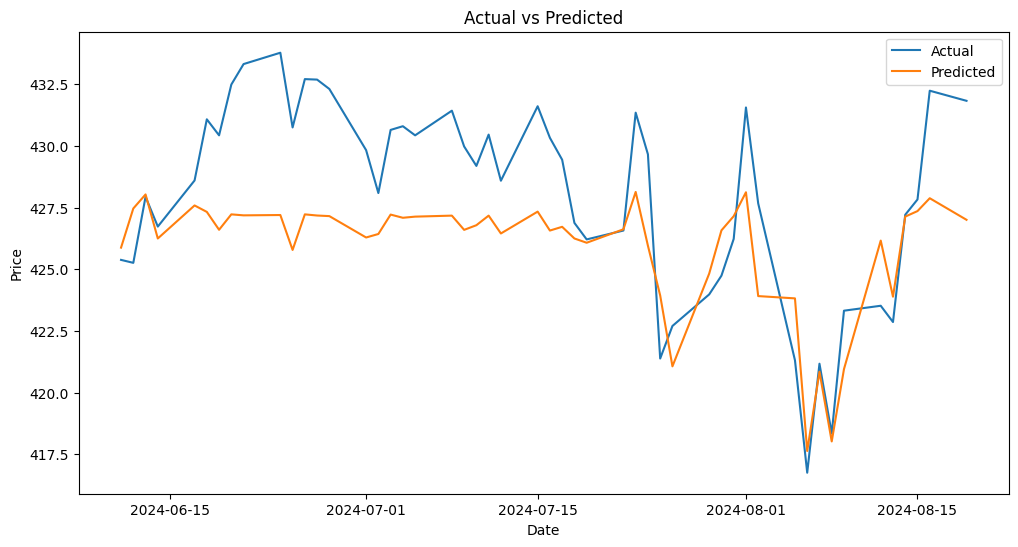

In [9]:
# Make predictions
predicted_outputs = model.predict(test_inputs)

# Calculate Mean Square Error
mse = mean_squared_error(test_outputs, predicted_outputs)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse:.2f}')

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(test_outputs.index, test_outputs, label='Actual')
plt.plot(test_outputs.index, predicted_outputs, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


The actual data looks far more volatile than the model estimated data.

In [10]:
import math

def periodic_returns(x):
    return (x[1:] - x[:-1]) / x[:-1]

def std_dev(x):
    return math.sqrt(x.var())

def volatility(x):
    return std_dev(periodic_returns(x))

def volatility_from_df(df):
    return math.sqrt((df.diff() / df).dropna().var())

display(f'Test data std_dev (Adj Close): {std_dev(test_outputs)}')
display(f'Predicted std_dev (Adj Close): {std_dev(predicted_outputs)}')
display(f'Test data volatility (Returns): {volatility_from_df(test_outputs)}')
display(f'Predicted data volatility (Returns): {volatility(predicted_outputs)}')


'Test data std_dev (Adj Close): 4.041013869211687'

'Predicted std_dev (Adj Close): 2.359744149251937'

'Test data volatility (Returns): 0.00658344976848652'

'Predicted data volatility (Returns): 0.00455214389054616'